# MISS with MNIST

MISS with MNIST and MLP

> The target function is assumed to be the raw logit, i.e., $\phi(x_{\text{test}}) = \theta^\top x_{\text{test}} + b$.

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model_train import MLP, SubsetSamper, MNISTModelOutput

Using device: cuda


In [2]:
# First, check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ks = [1, 2, 5, 10]
# targets = ["probability", "abs_probability", "test_loss", "abs_test_loss", "avg_abs_test_loss", "abs_avg_test_loss"]
# methods = ["TRAK", "Adaptive TRAK", "IF", "Adaptive IF"]
methods = ["TRAK", "Adaptive TRAK"]
seed = 0
ensemble_size = 5

num_methods, num_experiments, num_ks = len(methods), 500, len(ks)

Using device: cuda


In [3]:
def data_generation(subset_remove):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Load MNIST data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # remove the corresponding index from the subset_remove
    sampler_train = SubsetSamper([i for i in range(5000) if i not in subset_remove])

    # portion_index_test = np.random.choice([i for i in range(500)], size=500, replace=False, p=None)
    sampler_test = SubsetSamper([i for i in range(500)])

    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_train)
    test_loader = DataLoader(test_dataset, batch_size=1, sampler=sampler_test)

    return train_loader, test_loader

In [4]:
def actual_effect_NN(subset_remove, original_value):
    train_loader, test_loader = data_generation(subset_remove)
    model = MLP().to(device)
    model.train_with_seed(train_loader, epochs=30, seed=0)
    reduced_value = model.get_model_output(test_loader)

    return torch.abs(reduced_value - original_value)

In [5]:
def score(i_th_test, k):
    TRAK_result = torch.load(f"./TRAK/results/seed_{seed}_k_{k}_ensemble_{ensemble_size}.pt")
    adaptive_TRAK_result = torch.load(f"./TRAK/results/seed_{seed}_k_{k}_ensemble_{ensemble_size}_adaptive.pt")

    original_value = 0

    scores = np.array([
        actual_effect_NN(TRAK_result[i_th_test], original_value)[i_th_test].cpu().detach().numpy(),
        actual_effect_NN(adaptive_TRAK_result[i_th_test], original_value)[i_th_test].cpu().detach().numpy(),
        # actual_effect_NN(IF_result[i_th_test], original_value)[i_th_test].cpu().detach().numpy(),
        # actual_effect_NN(adaptive_IF_result[i_th_test], original_value)[i_th_test].cpu().detach().numpy()
    ])

    return scores

In [6]:
# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks, weights=[5, 4, 3, 2, 1]):
    num_methods, num_experiments = ranks.shape

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = weights[rank]

    total_weighted_borda_count = weighted_borda_count.sum(axis=1)

    return total_weighted_borda_count

In [7]:
scores_array = np.array(Parallel(n_jobs=20)(delayed(score)(i, k) for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

Borda_result = np.array(Parallel(n_jobs=20)(delayed(Borda_count)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda
Epoch 1, Loss: 1.0339410297478302
Epoch 1, Loss: 1.034050483869601
Epoch 1, Loss: 1.0320450963476036
Epoch 1, Loss: 1.0339465654349025
Epoch 2, Loss: 0.40517760143627096
Epoch 1, Loss: 1.0382282336552937
Epoch 2, Loss: 0.40608094840110104
Epoch 1, Loss: 1.032294922237155
Epoch 2, Loss: 0.4115685809733747
Epoch 1, Loss: 1.0378337880739799
Epoch 1, Loss: 1.0341691899148724
Epoch 1, Loss: 1.039558626138247
Epoch 1, Loss: 1.034670259756378
Epoch 1, Loss: 1.0318756890070588
Epoch 1, Loss: 1.0352516110184826
Epoch 1, Loss: 1.0339909822125979
Epoch 2, Loss: 0.4073592235770407
Epoch 1, Loss: 1.0342412013796312
Epoch 3, L

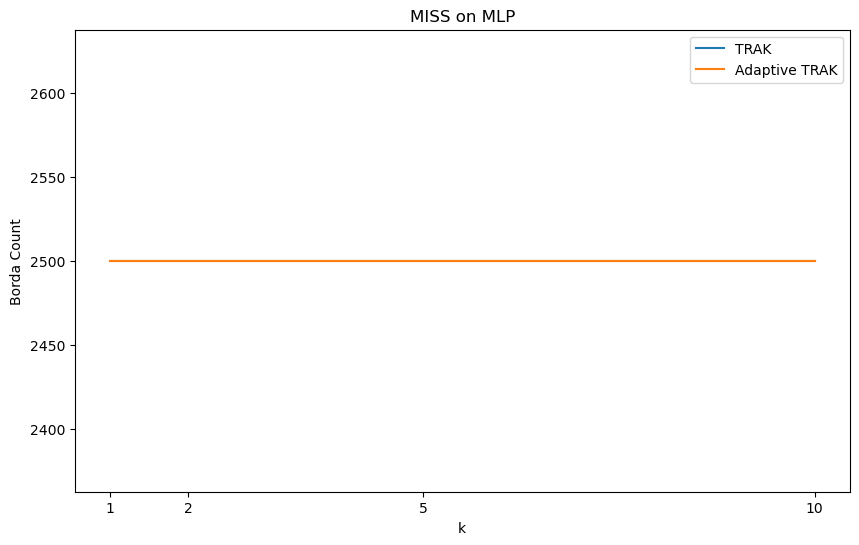

In [8]:
plt.figure(figsize=(10, 6))  # Create a single plot

# Your data processing and plotting code here

plt.title(f'MISS on MLP')
plt.xlabel('k')
plt.ylabel('Borda Count')

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, Borda_result[:, method_idx], label=method_name)

plt.xticks(ks)
plt.legend(methods)

plt.show()

In [9]:
np.array(Parallel(n_jobs=20)(delayed(Borda_count)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

array([[2500, 2500],
       [2500, 2500],
       [2500, 2500],
       [2500, 2500]])

In [10]:
scores_ks_method_combo.shape

(4, 2, 500)

In [14]:
scores_ks_method_combo[:,:,0]

array([[9.538739, 9.538739],
       [9.507764, 9.507764],
       [8.267743, 8.267743],
       [8.423287, 8.423287]], dtype=float32)

In [19]:
bo = True
for k in ks:
    TRAK_result = torch.load(f"./TRAK/MISS/seed_{seed}_k_{k}_ensemble_{ensemble_size}.pt")
    adaptive_TRAK_result = torch.load(f"./TRAK/MISS/seed_{seed}_k_{k}_ensemble_{ensemble_size}_adaptive.pt")
    bo = bo and torch.equal(TRAK_result, adaptive_TRAK_result)

print(bo)

True
